In [2]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [3]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [4]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
#df.head()

In [5]:
# y_eta
edges_eta = [0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37]

# y_pt
edges_pt_bkg = [20,  25,  30,  35,  40,  45, 50, 55, 490]
edges_pt_sig =edges_pt_bkg


# evt-mu  [5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40]
edges_mu_bkg =  [0., 16.,18., 20., 22., 24., 26., 28., 30., 32.,
               34., 36., 38., 40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.,
               62., 64.,66., 68., 100]
edges_mu_sig = edges_mu_bkg

# Créer des axes de structure de bins
axis_eta = hist.axis.Variable(edges_eta,    name="eta", label=r"$\eta$")

# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")

# Créer des axes de structure de bins
axis_mu_sig = hist.axis.Variable(edges_mu_sig, name='evt_mu', label=r"$evt_\mu$")
axis_mu_bkg = hist.axis.Variable(edges_mu_bkg, name='evt_mu', label=r"$evt_\mu$")

In [6]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

In [7]:
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])
#df.head()

In [8]:
# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin = axis_eta.index(df['y_abs_eta']))

# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones py_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig = axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg = axis_pt_bkg.index(df['y_pt']))

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(mu_bin_sig = axis_mu_sig.index(df['evt_mu']))       #Mapper les valeur de evt_mu aux bins définis par axis_mu_sig.
df = df.assign(mu_bin_bkg = axis_mu_bkg.index(df['evt_mu']))
#df.head()

In [9]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

print(f'    Signal dataset size = {len(df_sig):7d}')
print(f'Background dataset size = {len(df_bkg):7d}')

    Signal dataset size = 2301038
Background dataset size =  186284


In [10]:
df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

print(f'    Signal dataset size = {len(df_sig_tight):7d}')
print(f'Background dataset size = {len(df_bkg_tight):7d}')

    Signal dataset size = 2132650
Background dataset size =   39568


### (Eta, pT) Compute efficiency and rejection for cut-based Tight identification

In [11]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
den_sig_EtapT= hist.Hist(axis_eta, axis_pt_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"])   #before CBT
den_bkg_EtapT= hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])


num_sig_tight_EtapT= hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])   #after CBT
num_bkg_tight_EtapT= hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

eff_sig_tight_EtapT= (num_sig_tight_EtapT/den_sig_EtapT).values()
efferr_sig_tight_EtapT= np.sqrt(eff_sig_tight_EtapT*(1.-eff_sig_tight_EtapT)/den_sig_EtapT.values()) # binomial uncertainty on efficiency

eff_bkg_tight_EtapT= (num_bkg_tight_EtapT/den_bkg_EtapT).values()
efferr_bkg_tight_EtapT= np.sqrt(eff_bkg_tight_EtapT*(1.-eff_bkg_tight_EtapT)/den_bkg_EtapT.values()) # binomial uncertainty on efficiency


In [12]:
# Convertir les histogrammes en listes ou arrays pour tracer avec matplotlib
eta = axis_eta.centers

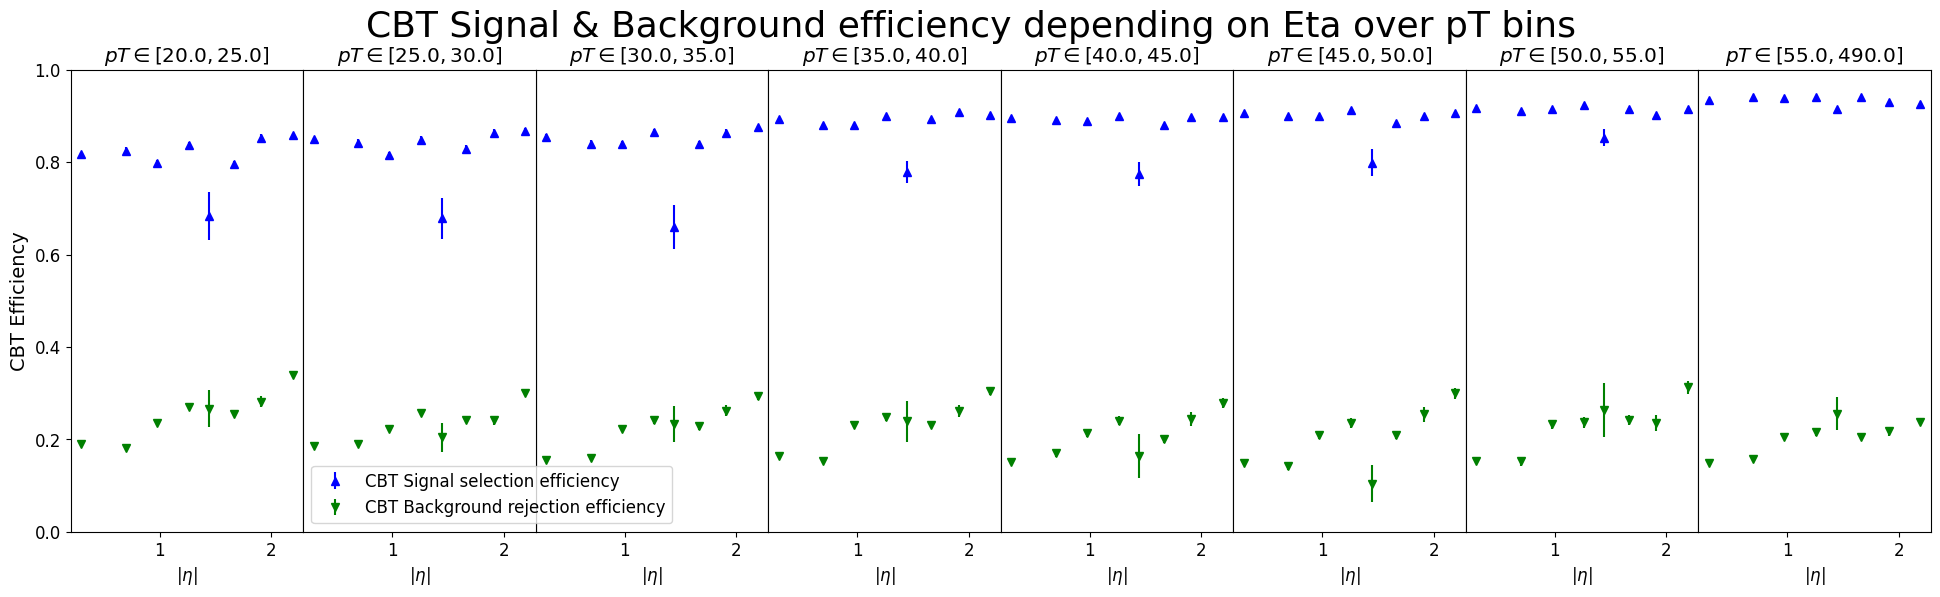

In [13]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(eta, eff_sig_tight_EtapT[:, i], efferr_sig_tight_EtapT[:, i],
        fmt="^", label='CBT Signal selection efficiency', color = 'blue')
    ax[i].errorbar(eta, eff_bkg_tight_EtapT[:, i], efferr_bkg_tight_EtapT[:, i],
        fmt="v", label='CBT Background rejection efficiency', color = 'green')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$pT \in [{}, {}]$".format(axis_pt_sig.edges[i], axis_pt_sig.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$|\eta|$')
    ax[i].set_ylim([0.0, 1.0])
    
        
ax[0].set_ylabel("CBT Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('CBT Signal & Background efficiency depending on Eta over pT bins', fontsize=26)



plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on Eta over pT bins.pdf")
plt.show()

In [14]:
print(eta)
print(eff_sig_tight_EtapT.shape)
print(eff_sig_tight_EtapT[:, :,].shape)
print(eff_sig_tight_EtapT[i].shape)
print(eff_sig_tight_EtapT[:, i].shape)
print(eff_sig_tight_EtapT[i, :].shape)

[0.3   0.7   0.975 1.26  1.445 1.665 1.91  2.19 ]
(8, 8)
(8, 8)
(8,)
(8,)
(8,)


In [52]:
# y_pt
edges_pt_sig = [ 20.,    25.,    30.,    35.,    40.,
                 45.,    50.,    55.,    60.,    65.,    
                 70.,    75.,    80.,    85.,    90.,
                 95.,   100.,   110.,   120.,   140.,   
                145.,   150.,   155.,   160.,   165.,
                175., 180.,  190., 200.,  205., 210., 215., 220., 225., 230., 235., 240., 245., 255., 265.,  280.,   
                285.,   290.,   300.,   305.,   315.,
                325.,   340.,   355.,   370.,   395.,   
                430.,   490.]
edges_pt_bkg = edges_pt_sig
# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")
# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones py_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig = axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg = axis_pt_bkg.index(df['y_pt']))

In [53]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
den_sig_EtapT= hist.Hist(axis_eta, axis_pt_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"])   #before CBT
den_bkg_EtapT= hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])


num_sig_tight_EtapT= hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])   #after CBT
num_bkg_tight_EtapT= hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

eff_sig_tight_EtapT= (num_sig_tight_EtapT/den_sig_EtapT).values()
efferr_sig_tight_EtapT= np.sqrt(eff_sig_tight_EtapT*(1.-eff_sig_tight_EtapT)/den_sig_EtapT.values()) # binomial uncertainty on efficiency

eff_bkg_tight_EtapT= (num_bkg_tight_EtapT/den_bkg_EtapT).values()
efferr_bkg_tight_EtapT= np.sqrt(eff_bkg_tight_EtapT*(1.-eff_bkg_tight_EtapT)/den_bkg_EtapT.values()) # binomial uncertainty on efficiency


In [54]:
# Convertir les histogrammes en listes ou arrays pour tracer avec matplotlib
pt_sig = axis_pt_sig.centers
pt_bkg = axis_pt_bkg.centers

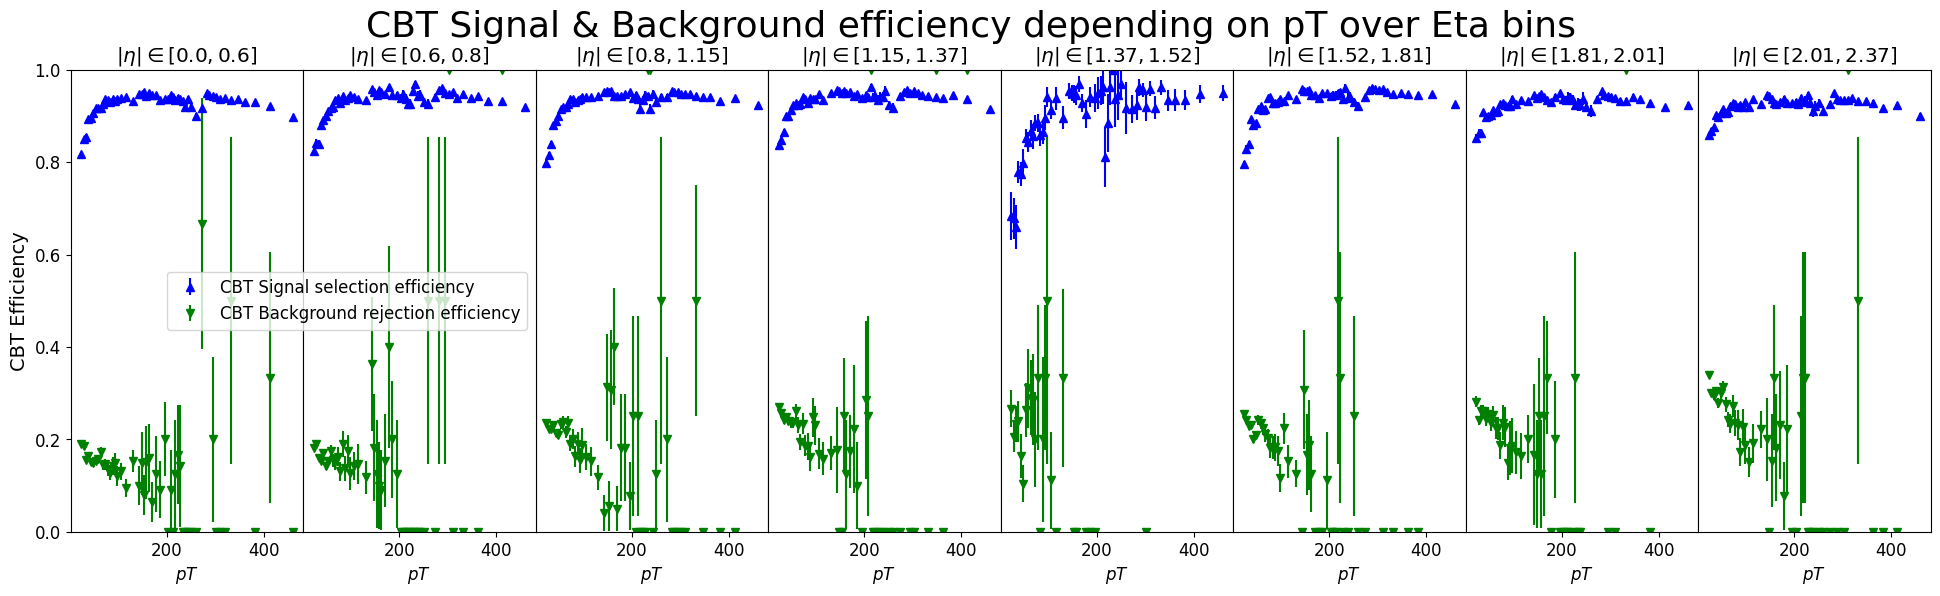

In [55]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight_EtapT[i], efferr_sig_tight_EtapT[i],
        fmt="^", label='CBT Signal selection efficiency', color = 'blue')
    ax[i].errorbar(pt_bkg, eff_bkg_tight_EtapT[i], efferr_bkg_tight_EtapT[i],
        fmt="v", label='CBT Background rejection efficiency', color = 'green')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$pT$')
    ax[i].set_ylim([0.0, 1.0])
    
        
ax[0].set_ylabel("CBT Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('CBT Signal & Background efficiency depending on pT over Eta bins', fontsize=26)



#plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on pT over Eta bins.pdf")
plt.show()

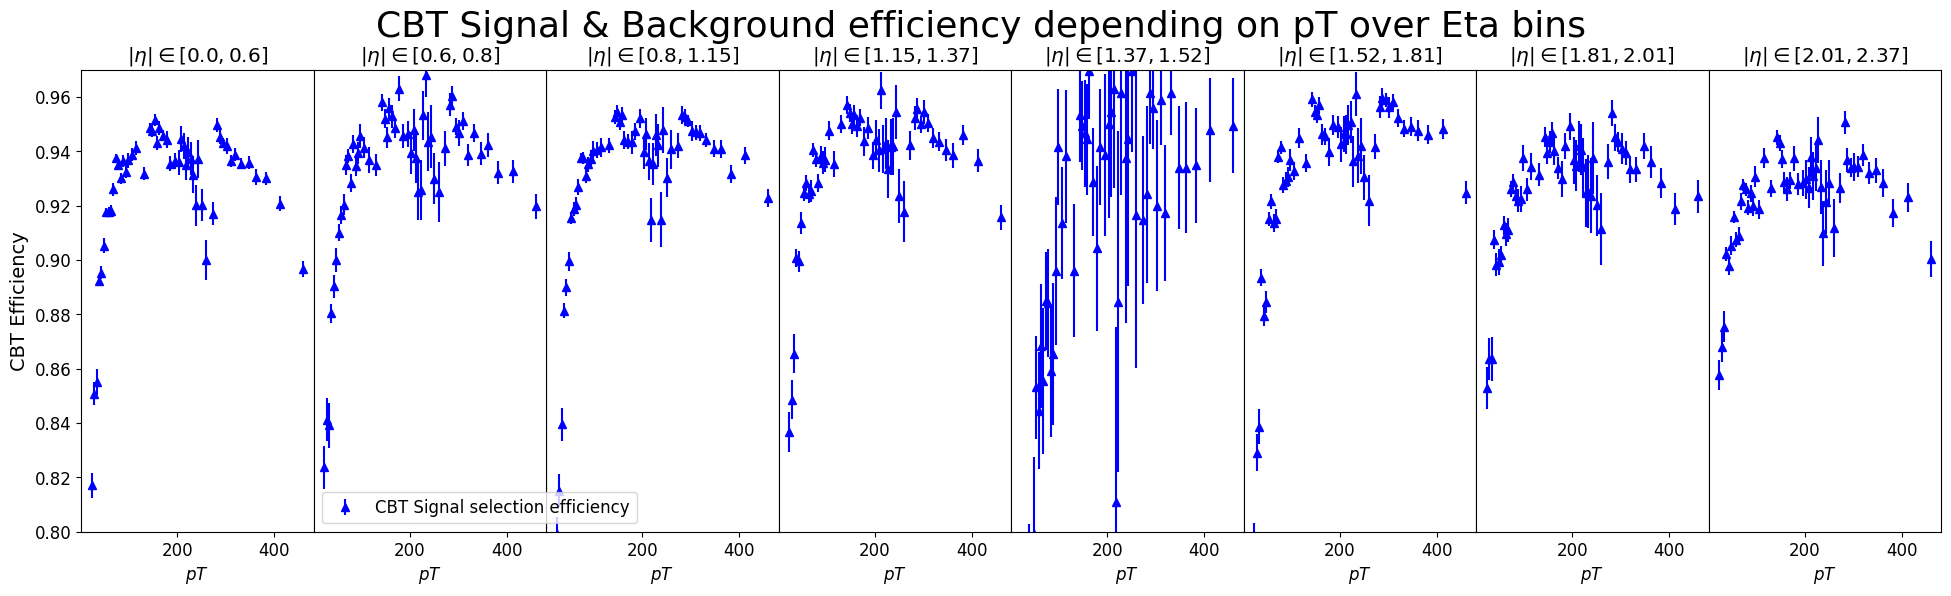

In [67]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight_EtapT[i], efferr_sig_tight_EtapT[i],
        fmt="^", label='CBT Signal selection efficiency', color = 'blue')
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$pT$')
    ax[i].set_ylim([0.8, 0.97])
    
        
ax[0].set_ylabel("CBT Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('CBT Signal & Background efficiency depending on pT over Eta bins', fontsize=26)



plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on pT over Eta bins Zoom sur drop efficiency.pdf")
plt.show()

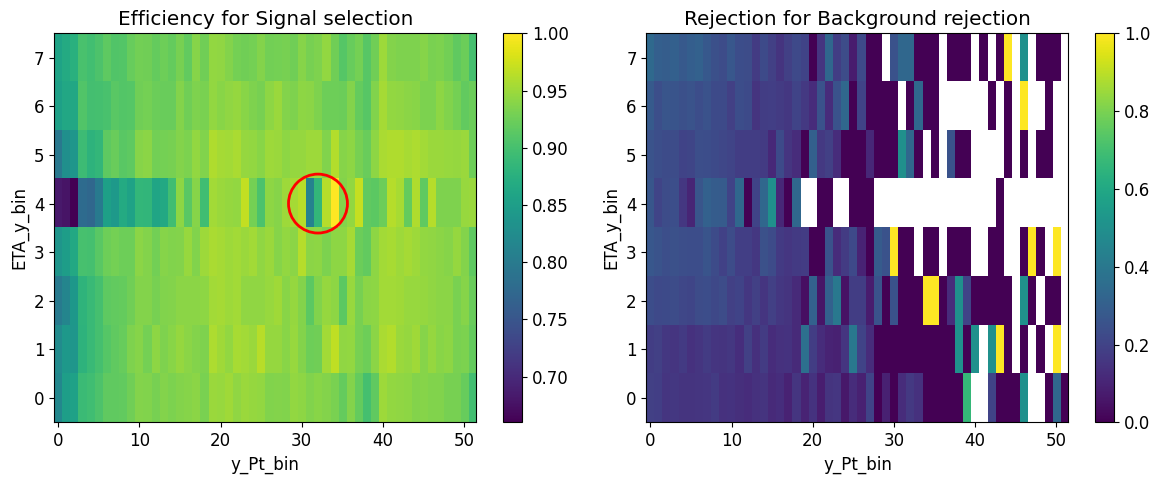

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pc_sig = ax[0].imshow(eff_sig_tight_EtapT, aspect='auto', origin='lower') # 'auto' : pixels are automatically adjusted 
                                                                        # to fill the axes area
fig.colorbar(pc_sig, ax=ax[0])
ax[0].set_title("Efficiency for Signal selection")
ax[0].set_xlabel("y_Pt_bin")
ax[0].set_ylabel("ETA_y_bin")

# Plotting efficiency for background
pc_bkg = ax[1].imshow(eff_bkg_tight_EtapT, aspect='auto', origin='lower')

fig.colorbar(pc_bkg, ax=ax[1])
ax[1].set_title("Rejection for Background rejection")
ax[1].set_xlabel("y_Pt_bin")
ax[1].set_ylabel("ETA_y_bin")


# Ajouter un cercle rouge à la position spécifiée
bin_index_eta = 4
bin_index_pT = 32
ax[0].scatter(bin_index_pT, bin_index_eta, s=1800, facecolors='none', edgecolors='r', linewidths=2)


plt.tight_layout()
plt.savefig(savedir+"BDT_PID_reject_effi/Heatmap_efficiency_Eta_pT_dropcircle.pdf")

plt.show()


In [61]:
bin_index = np.digitize(250, edges_pt_sig) - 1  # 

print(f"pT = {250} GeV est dans le bin index {bin_index}, dans à l'intervalle [{edges_pt_sig[bin_index]}, {edges_pt_sig[bin_index+1]}]")


pT = 250 GeV est dans le bin index 37, dans à l'intervalle [245.0, 255.0]


In [65]:
bin_index_eta = 4
bin_index_pT = 31

# Limites du bin en eta
eta_min = edges_eta[bin_index_eta]
eta_max = edges_eta[bin_index_eta + 1]

# Limites du bin en pT
pT_min = edges_pt_sig[bin_index_pT]
pT_max = edges_pt_sig[bin_index_pT + 1]

# Valeur de la heatmap dans ce bin
heatmap_value = eff_sig_tight_EtapT[bin_index_eta, bin_index_pT]

print(f"Index des bins ({bin_index_eta}, {bin_index_pT}):")
print(f"Intervalle eta: [{eta_min}, {eta_max}]")
print(f"Intervalle pT: [{pT_min}, {pT_max}]")
print(f"Valeur eff: {heatmap_value}")

Index des bins (4, 31):
Intervalle eta: [1.37, 1.52]
Intervalle pT: [215.0, 220.0]
Valeur eff: 0.8108108108108109


In [38]:
den_sig_EtapT

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable(array([ 20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.,  90.,  95., 100., 110., 120., 140., 145., 150.,
       155., 160., 165., 175., 190., 205., 215., 225., 230., 240., 245.,
       255., 265., 280., 285., 290., 300., 305., 315., 325., 340., 355.,
       370., 395., 430., 490.]), name='pt', label='$p_T$ [GeV]'),
  storage=Double()) # Sum: 1756735.0 (2301038.0 with flow)

In [39]:
num_sig_tight_EtapT

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable(array([ 20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.,  90.,  95., 100., 110., 120., 140., 145., 150.,
       155., 160., 165., 175., 190., 205., 215., 225., 230., 240., 245.,
       255., 265., 280., 285., 290., 300., 305., 315., 325., 340., 355.,
       370., 395., 430., 490.]), name='pt', label='$p_T$ [GeV]'),
  storage=Double()) # Sum: 1627357.0 (2132650.0 with flow)

### (Eta, Mu) Compute efficiency and rejection for cut-based Tight identification

In [18]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
den_sig_Etamu= hist.Hist(axis_eta, axis_mu_sig).fill(df_sig["y_abs_eta"], df_sig["evt_mu"])   #before CBT
den_bkg_Etamu= hist.Hist(axis_eta, axis_mu_bkg).fill(df_bkg["y_abs_eta"], df_bkg["evt_mu"])


num_sig_tight_Etamu= hist.Hist(axis_eta, axis_mu_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["evt_mu"])   #after CBT
num_bkg_tight_Etamu= hist.Hist(axis_eta, axis_mu_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["evt_mu"])

eff_sig_tight_Etamu= (num_sig_tight_Etamu/den_sig_Etamu).values()
efferr_sig_tight_Etamu= np.sqrt(eff_sig_tight_Etamu*(1.-eff_sig_tight_Etamu)/den_sig_Etamu.values()) # binomial uncertainty on efficiency

eff_bkg_tight_Etamu= (num_bkg_tight_Etamu/den_bkg_Etamu).values()
efferr_bkg_tight_Etamu= np.sqrt(eff_bkg_tight_Etamu*(1.-eff_bkg_tight_Etamu)/den_bkg_Etamu.values()) # binomial uncertainty on efficiency


In [19]:
# Convertir les histogrammes en listes ou arrays pour tracer avec matplotlib
mu_sig = axis_mu_sig.centers
mu_bkg = axis_mu_bkg.centers

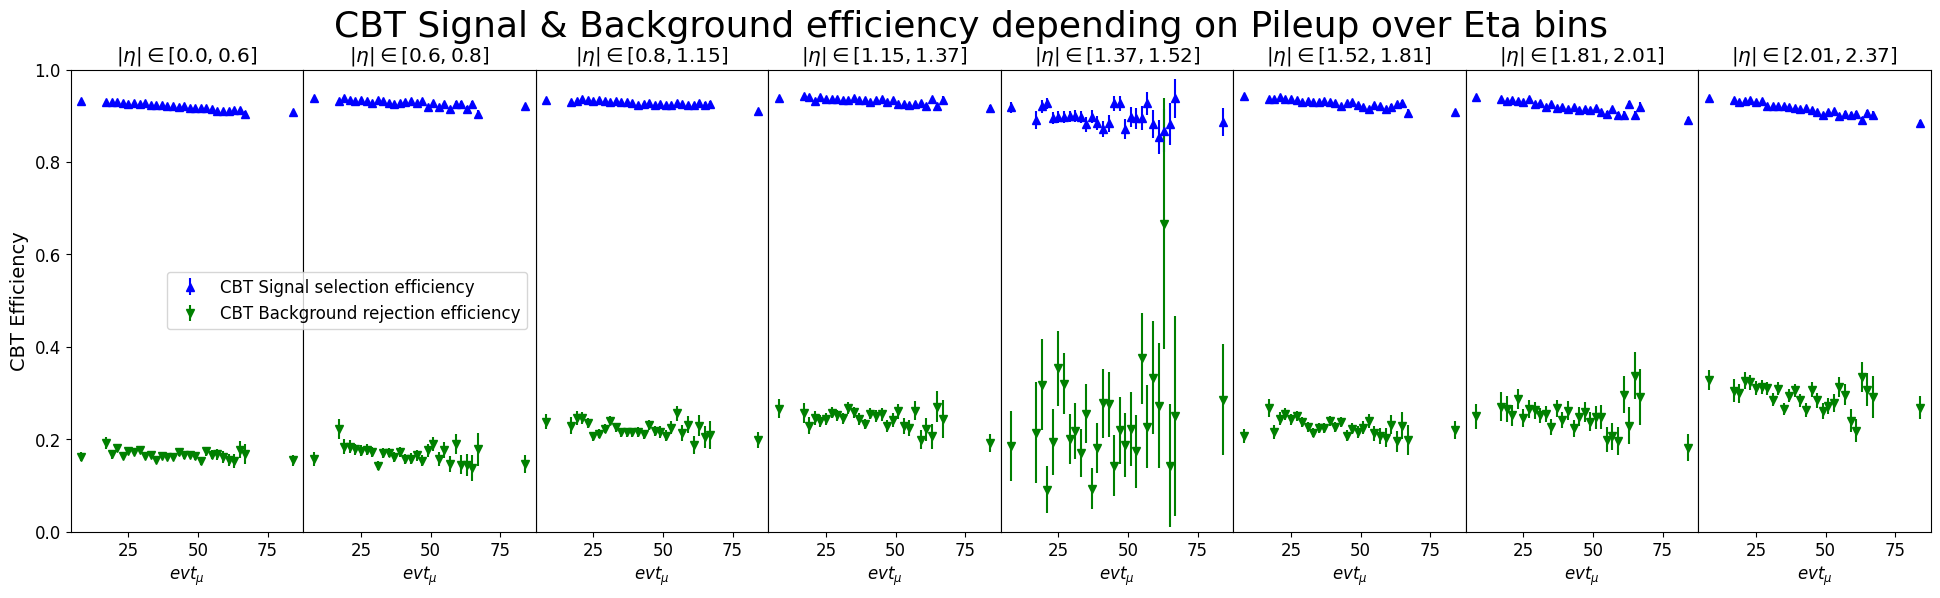

In [20]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu_sig, eff_sig_tight_Etamu[i], efferr_sig_tight_Etamu[i],
        fmt="^", label='CBT Signal selection efficiency', color = 'blue')
    ax[i].errorbar(mu_bkg, eff_bkg_tight_Etamu[i], efferr_bkg_tight_Etamu[i],
        fmt="v", label='CBT Background rejection efficiency', color = 'green')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$evt_{\mu}$')
    ax[i].set_ylim([0.0, 1.0])
    
        
ax[0].set_ylabel("CBT Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('CBT Signal & Background efficiency depending on Pileup over Eta bins', fontsize=26)



plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on Pileup over Eta bins.pdf")
plt.show()

### (pT, Mu) Compute efficiency and rejection for cut-based Tight identification

In [21]:
# y_pt
edges_pt_sig = [ 20.,    25.,    30.,    35.,    40.,
                 45.,    50.,    55.,    60.,    65.,    
                 70.,    75.,    80.,    85.,    90.,
                 95.,   100.,   110.,   120.,   140.,   
                145.,   150.,   155.,   160.,   165.,
                175.,   190.,   205.,   230.,   280.,   
                285.,   290.,   300.,   305.,   315.,
                325.,   340.,   355.,   370.,   395.,   
                430.,   490.]
edges_pt_bkg = edges_pt_sig
# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")
# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones py_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig = axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg = axis_pt_bkg.index(df['y_pt']))

In [22]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
den_sig_pTmu = hist.Hist(axis_pt_sig, axis_mu_sig).fill(df_sig["y_pt"], df_sig["evt_mu"])   #before CBT
den_bkg_pTmu = hist.Hist(axis_pt_sig, axis_mu_bkg).fill(df_bkg["y_pt"], df_bkg["evt_mu"])


num_sig_tight_pTmu = hist.Hist(axis_pt_sig, axis_mu_sig).fill(df_sig_tight["y_pt"], df_sig_tight["evt_mu"])   #after CBT
num_bkg_tight_pTmu = hist.Hist(axis_pt_sig, axis_mu_bkg).fill(df_bkg_tight["y_pt"], df_bkg_tight["evt_mu"])

eff_sig_tight_pTmu = (num_sig_tight_pTmu/den_sig_pTmu).values()
efferr_sig_tight_pTmu = np.sqrt(eff_sig_tight_pTmu*(1.-eff_sig_tight_pTmu)/den_sig_pTmu.values()) # binomial uncertainty on efficiency

eff_bkg_tight_pTmu = (num_bkg_tight_pTmu/den_bkg_pTmu).values()
efferr_bkg_tight_pTmu = np.sqrt(eff_bkg_tight_pTmu*(1.-eff_bkg_tight_pTmu)/den_bkg_pTmu.values()) # binomial uncertainty on efficiency


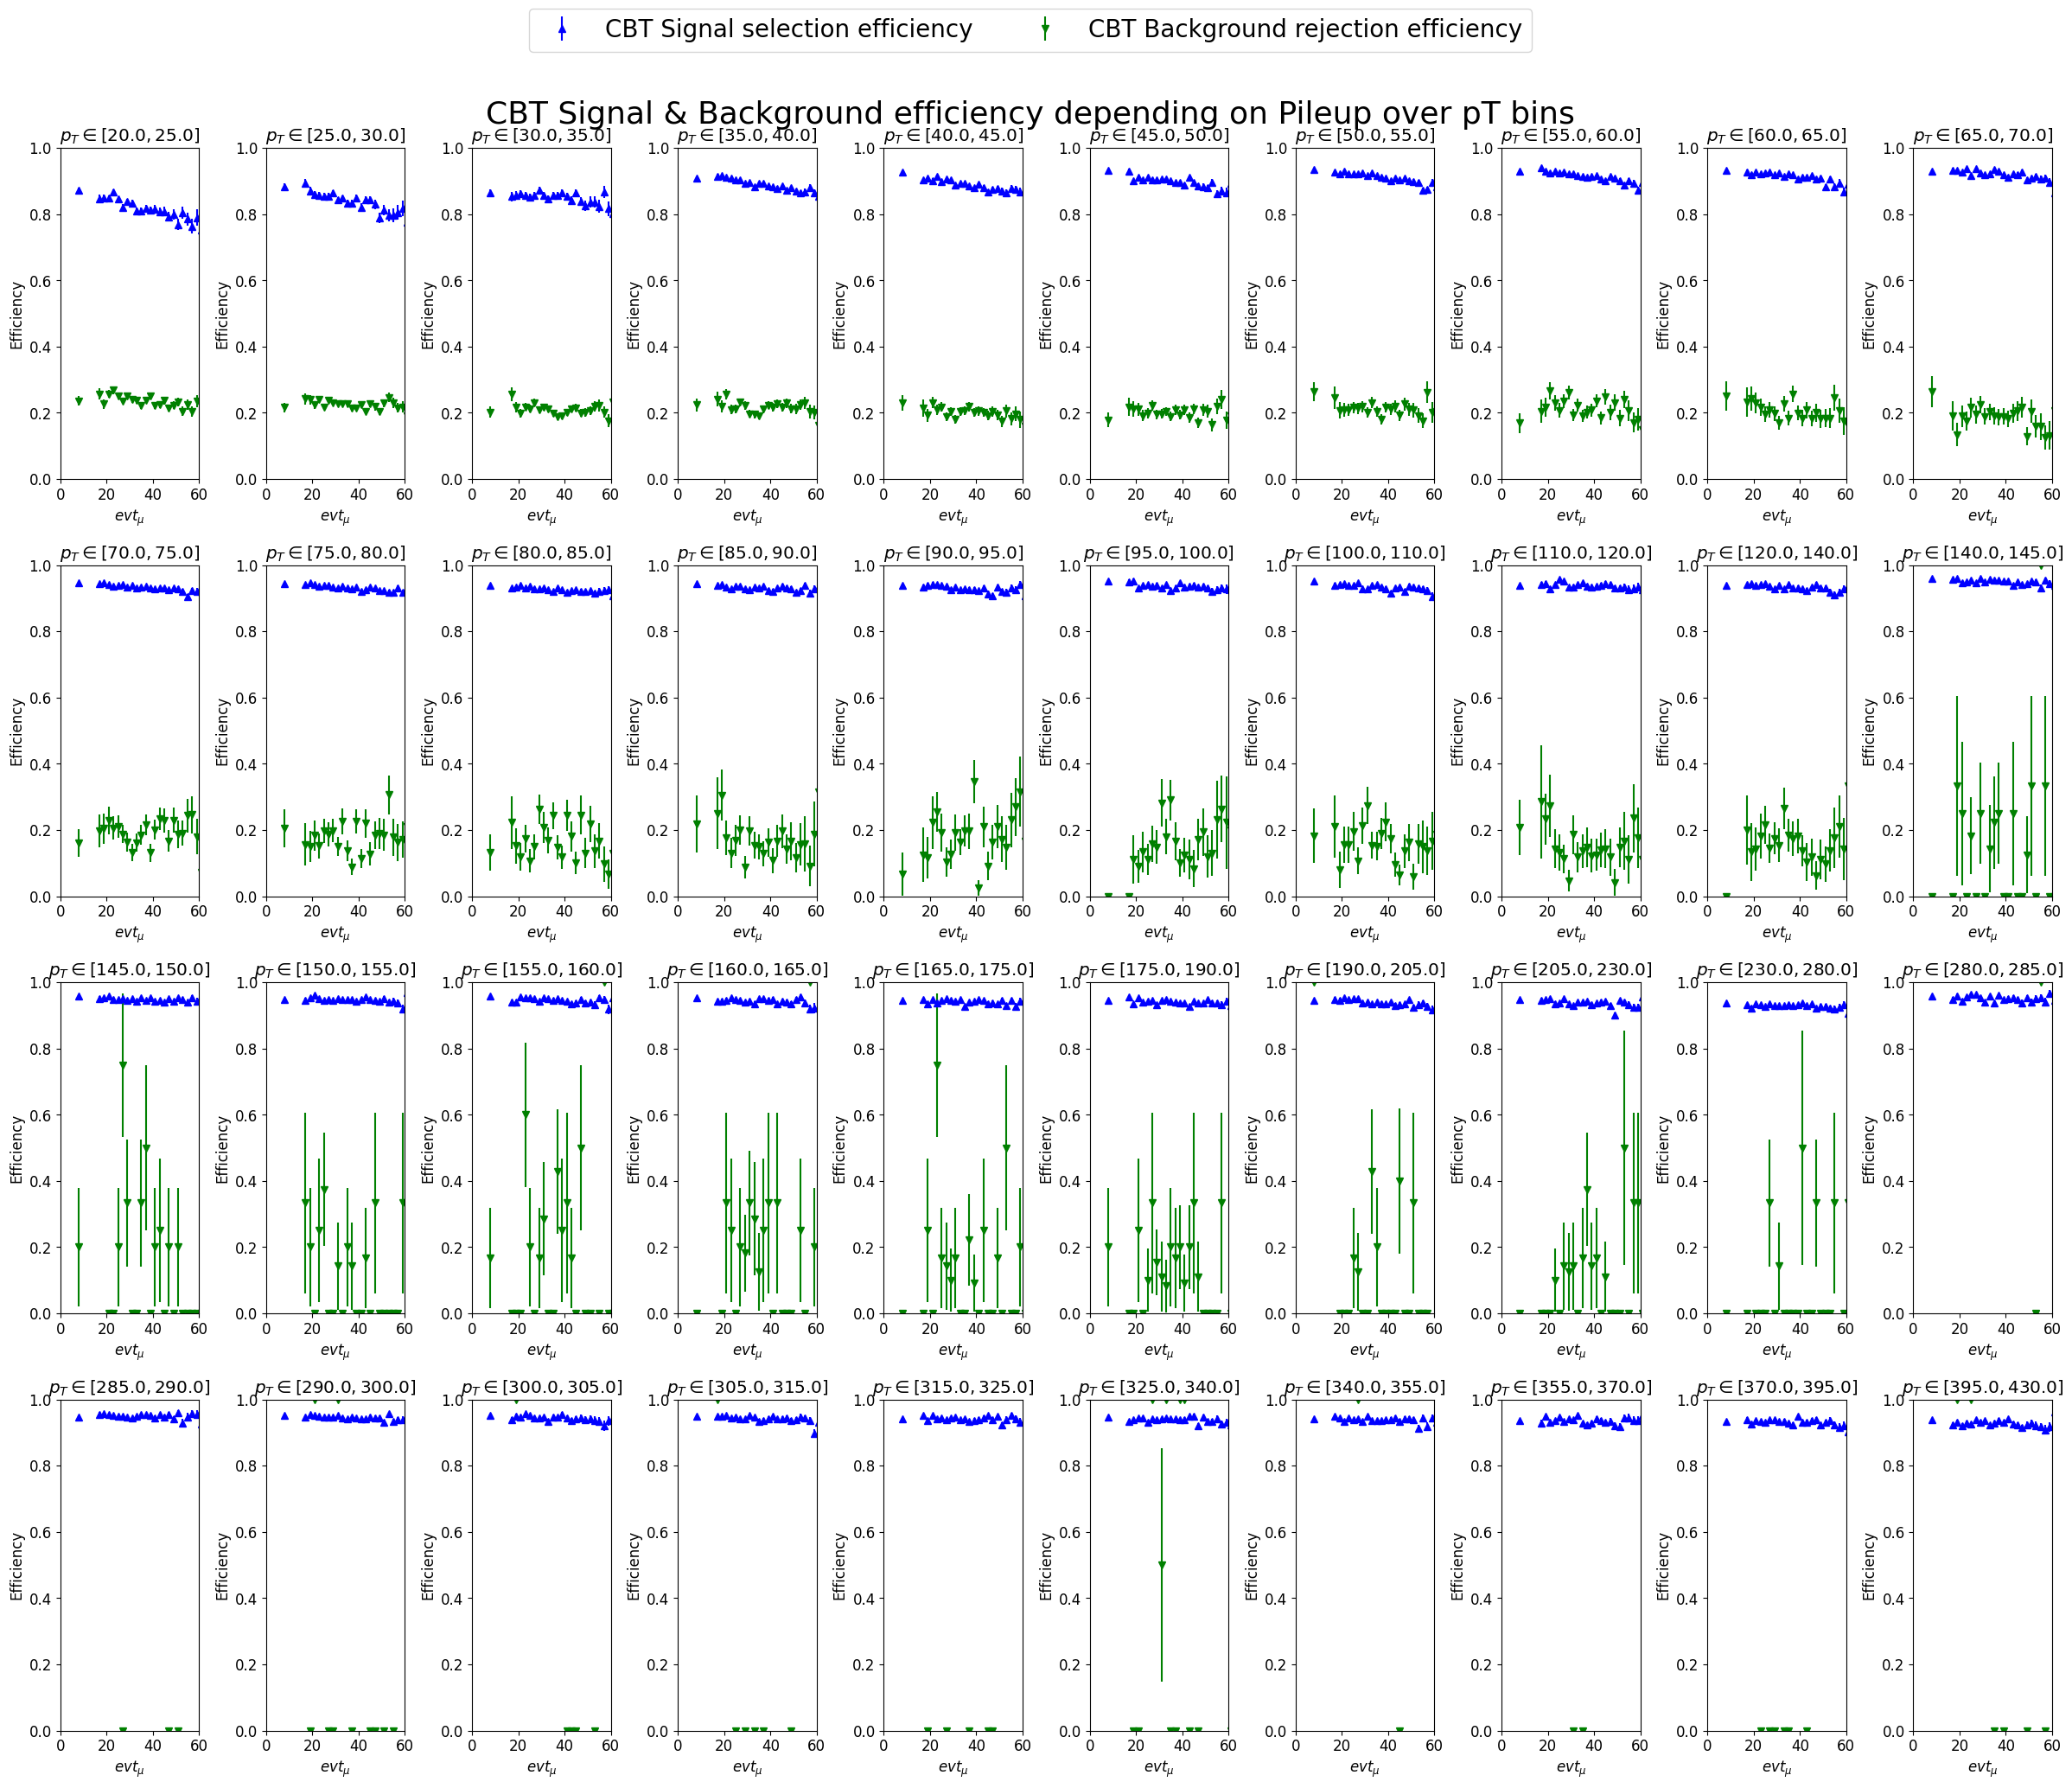

In [23]:
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(24, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

handles = []
labels = []

for i in range(40):
    # Accès à l'axe correct
    ax = axes[i // 10, i % 10]

    errorbar_tight_sig = ax.errorbar(mu_sig, eff_sig_tight_pTmu[i], efferr_sig_tight_pTmu[i],
                                     fmt="^", label='CBT Signal selection efficiency', color='blue')
    errorbar_tight_bkg = ax.errorbar(mu_bkg, eff_bkg_tight_pTmu[i], efferr_bkg_tight_pTmu[i],
                                     fmt="v", label='CBT Background rejection efficiency', color='green')

    # Extraction des lignes pour la légende lors du premier subplot
    if i == 0:
        handles.append(errorbar_tight_sig)
        labels.append('CBT Signal selection efficiency')
        handles.append(errorbar_tight_bkg)
        labels.append('CBT Background rejection efficiency')

    # Titre et labels des axes
    ax.set_title(f"$p_T \in [{edges_pt_sig[i]:.1f}, {edges_pt_sig[i+1]:.1f}]$")
    ax.set_ylim(0.0, 1.0)
    ax.set_xlim([0.0, 60.0])
    ax.set_xlabel('$evt_{\mu}$')
    ax.set_ylabel('Efficiency')
    
fig.suptitle('CBT Signal & Background efficiency depending on Pileup over pT bins', fontsize=26)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, fontsize=20)

plt.tight_layout()

plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on Pileup over pT bins.pdf")

plt.show()


### (Eta, pT, Mu) Compute efficiency and rejection for cut-based Tight identification

In [24]:
edges_pt_bkg = [20,  25,  30,  35,  40,  45, 50, 55, 490]
edges_pt_sig =edges_pt_bkg
# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")
# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones py_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig = axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg = axis_pt_bkg.index(df['y_pt']))

In [25]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
den_sig = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"], df_sig["evt_mu"])   #before CBT
den_bkg = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"], df_bkg["evt_mu"])


num_sig_tight = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig_tight["y_abs_eta"], 
                                                                       df_sig_tight["y_pt"], df_sig_tight["evt_mu"])   #after CBT
num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_tight["y_abs_eta"], 
                                                                       df_bkg_tight["y_pt"], df_bkg_tight["evt_mu"])

eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values()) # binomial uncertainty on efficiency

eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values()) # binomial uncertainty on efficiency


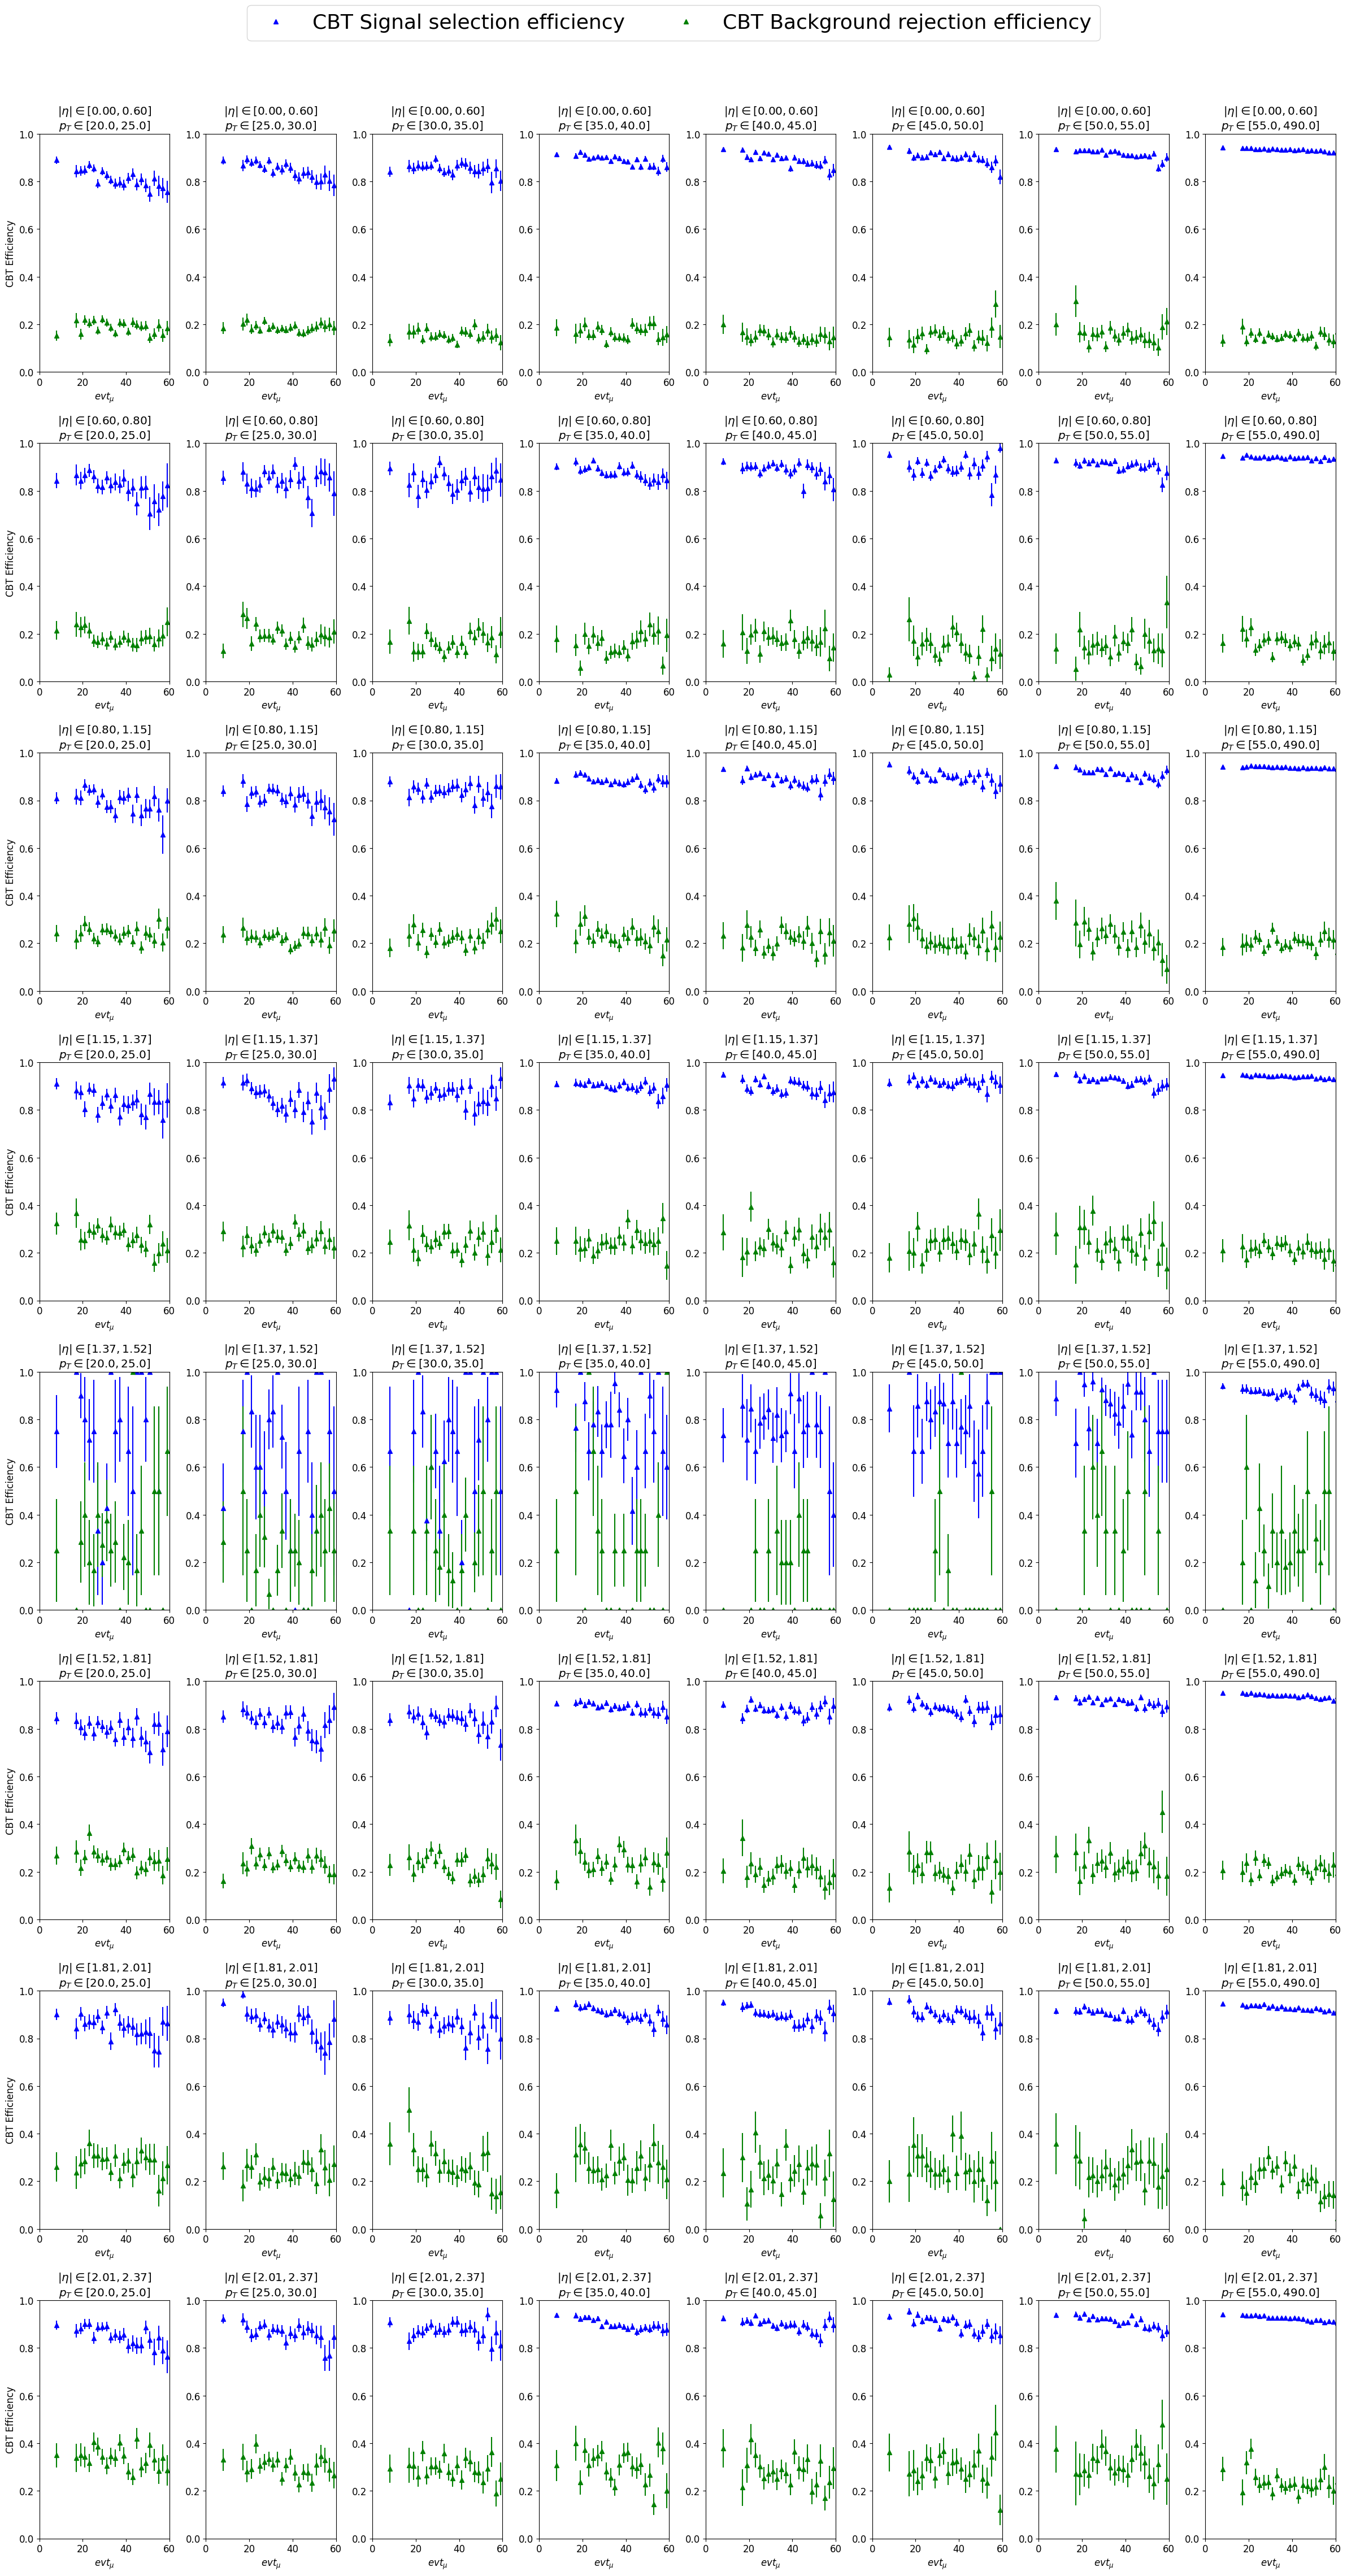

In [26]:
# Number of subplots
num_eta_bins = len(axis_eta)  
num_mu_bins = len(axis_mu_sig)  
num_pt_bins = len(axis_pt_sig)

# Create subplots
fig, axs = plt.subplots(nrows=num_eta_bins, ncols=num_pt_bins, figsize=(24, 44))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Initialize handles and labels for the legend
handles = []
labels = []

# Loop over eta and pt bins
for eta_idx in range(num_eta_bins):
    for pt_idx in range(num_pt_bins):
        ax = axs[eta_idx, pt_idx]  # Subplot for efficiency
        
        # Errorbar for tight efficiency
        errorbar_tight_sig = ax.errorbar(mu_sig, eff_sig_tight[eta_idx, pt_idx, :], efferr_sig_tight[eta_idx, pt_idx, :], 
                                     fmt='^', linestyle='', color='blue', 
                                     label='CBT Signal efficiency' if eta_idx == 0 and pt_idx == 0 else "")
        
        errorbar_tight_bkg = ax.errorbar(mu_bkg, eff_bkg_tight[eta_idx, pt_idx, :], efferr_bkg_tight[eta_idx, pt_idx, :], 
                                     fmt='^', linestyle='', color='green', 
                                     label='CBT Background rejection' if eta_idx == 0 and pt_idx == 0 else "")

        # Extract lines for the legend
        if eta_idx == 0 and pt_idx == 0:
            
            handles.append(errorbar_tight_sig[0])
            labels.append('CBT Signal selection efficiency')
            
            handles.append(errorbar_tight_bkg[0])
            labels.append('CBT Background rejection efficiency')

            
        # Title and axis labels
        ax.set_title(f"$|\eta| \in [{edges_eta[eta_idx]:.2f}, {edges_eta[eta_idx+1]:.2f}]$\n$p_T \in [{edges_pt_sig[pt_idx]:.1f}, {edges_pt_sig[pt_idx+1]:.1f}]$")
        ax.set_ylim(0.0, 1.0)
        ax.set_xlim([0.0, 60.0])
        if pt_idx == 0:
            ax.set_ylabel('CBT Efficiency')
        if eta_idx == eta_idx:
            ax.set_xlabel('$evt_{\mu}$')

# Add a global legend to the figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, fontsize=26)

plt.tight_layout()

plt.savefig(savedir+"BDT_PID_reject_effi/CBT Signal & Background efficiency depending on Pileup over pT & Eta bins.pdf")

plt.show()
